<a href="https://colab.research.google.com/github/akritidu/news_category_prediction/blob/main/News_category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection  import train_test_split

import pandas as pd

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/BBC News Train.csv")
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [53]:
Category = df['Category'].unique()
print(Category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [ ]:
df = df.drop(df.columns[0], axis=1) 

In [ ]:
X  = df['Text']

In [ ]:
y = pd.get_dummies(df['Category']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (1490, 5)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
"/content/drive/MyDrive/Dataset/glove.6B.100d.txt"

'/content/drive/MyDrive/Dataset/glove.6B.100d.txt'

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros


embeddings_dictionary = dict()

glove_file = open("/content/drive/MyDrive/Dataset/glove.6B.100d.txt")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# **RNN**

In [58]:
sequence_input = Input(shape=(maxlen,))
model = Embedding( vocab_size , 100, weights=[embedding_matrix], trainable=False)(sequence_input)
model =  SimpleRNN(25, return_sequences=True)(model)
model  = GlobalMaxPooling1D()(model)
target = Dense(5, activation="sigmoid")(model)
RNN_model = Model(sequence_input, target)
RNN_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
history =RNN_model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
8/8 [==============================] - 1s 78ms/step - loss: 0.3951 - accuracy: 0.7576 - val_loss: 0.3954 - val_accuracy: 0.7197
Epoch 2/15
8/8 [==============================] - 1s 75ms/step - loss: 0.3869 - accuracy: 0.7702 - val_loss: 0.3876 - val_accuracy: 0.7615
Epoch 3/15
8/8 [==============================] - 1s 73ms/step - loss: 0.3785 - accuracy: 0.8038 - val_loss: 0.3798 - val_accuracy: 0.7992
Epoch 4/15
8/8 [==============================] - 1s 74ms/step - loss: 0.3704 - accuracy: 0.8195 - val_loss: 0.3722 - val_accuracy: 0.8033
Epoch 5/15
8/8 [==============================] - 1s 72ms/step - loss: 0.3624 - accuracy: 0.8269 - val_loss: 0.3650 - val_accuracy: 0.8159
Epoch 6/15
8/8 [==============================] - 1s 74ms/step - loss: 0.3547 - accuracy: 0.8416 - val_loss: 0.3572 - val_accuracy: 0.8285
Epoch 7/15
8/8 [==============================] - 1s 72ms/step - loss: 0.3466 - accuracy: 0.8468 - val_loss: 0.3504 - val_accuracy: 0.8201
Epoch 8/15
8/8 [===========

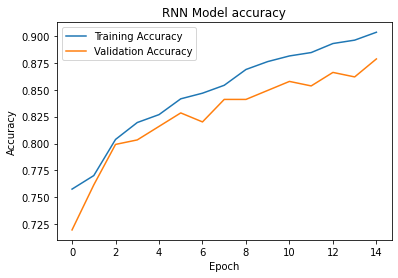

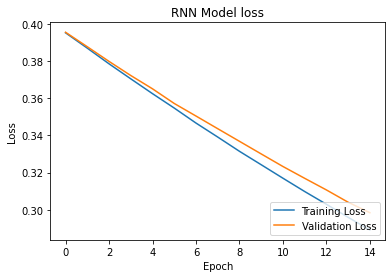

In [62]:
import matplotlib.pyplot as plt
## Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

## Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

# CNN

In [63]:
sequence_input = Input(shape=(maxlen,))
model = Embedding( vocab_size , 100, weights=[embedding_matrix], trainable=False)(sequence_input)
model =  SpatialDropout1D(0.5)(model)
model = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(model)
model  = GlobalMaxPooling1D()(model)
target = Dense(5, activation="sigmoid")(model)
CNN_model = Model(sequence_input, target)
CNN_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [64]:
history = CNN_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 2s 154ms/step - loss: 0.5794 - accuracy: 0.2329 - val_loss: 0.5124 - val_accuracy: 0.2636
Epoch 2/10
8/8 [==============================] - 1s 135ms/step - loss: 0.4653 - accuracy: 0.3882 - val_loss: 0.3971 - val_accuracy: 0.7155
Epoch 3/10
8/8 [==============================] - 1s 132ms/step - loss: 0.3945 - accuracy: 0.5719 - val_loss: 0.3411 - val_accuracy: 0.8368
Epoch 4/10
8/8 [==============================] - 1s 132ms/step - loss: 0.3355 - accuracy: 0.7671 - val_loss: 0.2990 - val_accuracy: 0.8954
Epoch 5/10
8/8 [==============================] - 1s 131ms/step - loss: 0.2954 - accuracy: 0.8248 - val_loss: 0.2613 - val_accuracy: 0.9163
Epoch 6/10
8/8 [==============================] - 1s 130ms/step - loss: 0.2670 - accuracy: 0.8416 - val_loss: 0.2284 - val_accuracy: 0.9289
Epoch 7/10
8/8 [==============================] - 1s 132ms/step - loss: 0.2387 - accuracy: 0.8688 - val_loss: 0.2064 - val_accuracy: 0.9372
Epoch 8/10
8/8 [====

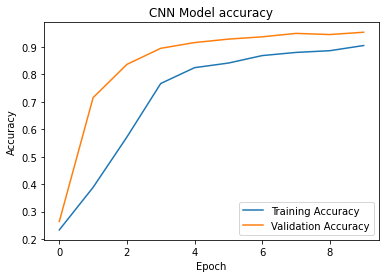

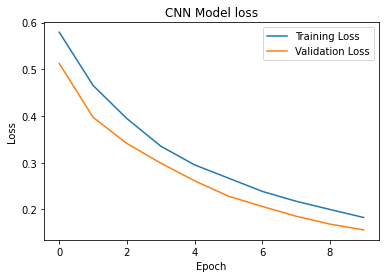

In [67]:
import matplotlib.pyplot as plt
## Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

## Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()